<h1><center><font size="6">Classification</font></center></h1>



In your second homework you need to create a model that predicts which passengers survived the Titanic shipwreck.

In [2]:
import pandas as pd
import numpy as np
import datetime
import sys
import os
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn import metrics

In [3]:
train_df=pd.read_csv('train.csv')
test_df=pd.read_csv('test.csv')

# <a id='3'>Data exploration</a>  

We check the shape of train and test dataframes and also show a selection of rows, to have an initial understanding of the data.



In [4]:
train_df.sample(5).head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
563,564,0,3,"Simmons, Mr. John",male,NaN,0,0,SOTON/OQ 392082,8.050,NaN,S
544,545,0,1,"Douglas, Mr. Walter Donald",male,50.0,1,0,PC 17761,106.425,C86,C
46,47,0,3,"Lennon, Mr. Denis",male,NaN,1,0,370371,15.500,NaN,Q
166,167,1,1,"Chibnall, Mrs. (Edith Martha Bowerman)",female,NaN,0,1,113505,55.000,E33,S
204,205,1,3,"Cohen, Mr. Gurshon ""Gus""",male,18.0,0,0,A/5 3540,8.050,NaN,S


In [5]:
test_df.sample(5).head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
91,983,3,"Pedersen, Mr. Olaf",male,NaN,0,0,345498,7.7750,NaN,S
218,1110,1,"Widener, Mrs. George Dunton (Eleanor Elkins)",female,50.0,1,1,113503,211.5000,C80,C
305,1197,1,"Crosby, Mrs. Edward Gifford (Catherine Elizabe...",female,64.0,1,1,112901,26.5500,B26,S
321,1213,3,"Krekorian, Mr. Neshan",male,25.0,0,0,2654,7.2292,F E57,C


In [6]:
print("Train: rows:{} cols:{}".format(train_df.shape[0], train_df.shape[1]))
print("Test:  rows:{} cols:{}".format(test_df.shape[0], test_df.shape[1]))

Train: rows:891 cols:12
Test:  rows:418 cols:11


Both **train** and **test** files contains the following values:  

* **PassengerID** - the index of the passenger (in the dataset);  
* **PClass** - the class of the passenger (from 1 to 3);
* **Name** - the name of the passenger;
* **Sex** - the sex of the passenger (female or male);  
* **Age** - the age (where available) of the passenger;  
* **SibSp** - the number of sibilings / spouses aboard of Titanic;  
* **Parch** - the number of parents / children aboard of Titanic;  
* **Ticket** - the ticket number;  
* **Fare** - the passenger fare (ticket cost);  
* **Cabin** - the cabin number;  
* **Embarked** - the place of embarcation of the passenger (C = Cherbourg, Q = Queenstown, S = Southampton).  

The **train** data has as well the target value, **Survived**.

It is important to have a good understanding of the data before going to create a model. Therefore we will explore the features.

Let's start by checking if there are missing data and unlabeled data.

Next, analyze the dependencies of the target variable on various features, such as Age, Sex, and so on, using approaches similar to those in the first homework.

Draw conclusions about what affects whether the passenger survives, check the distribution of features in the train and test data. 

How much percent of each columns do have valid values?
Cabin          77.10
Age            19.87
Embarked        0.22
PassengerId     0.00
Survived        0.00
Pclass          0.00
Name            0.00
Sex             0.00
SibSp           0.00
Parch           0.00
Ticket          0.00
Fare            0.00
dtype: float64


How many people survived?
Survived
0    61.6%
1    38.4%
Name: proportion, dtype: object


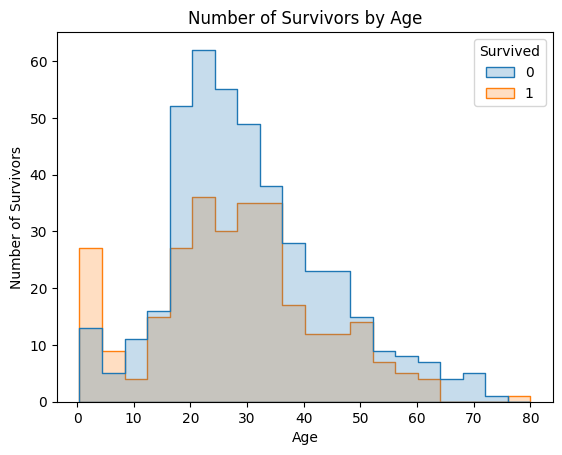

In [19]:
import seaborn as sns

#Check which columns can be dropped because of too much missing data
column_fill_percentage = train_df.isnull().mean().round(4).mul(100).sort_values(ascending=False)
print("How much percent of each columns do have valid values?")
print(column_fill_percentage)
print("\n")
# @Keitlin: I would drop Cabin and decide on what to do with the age. Probably drop it too? Replacing the values with the median would be
# an option too, but this could falsify some conclusions

# How many people survived in total?
survival_rate = train_df['Survived'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
print("How many people survived?")
print(survival_rate)

# Children vs Adults vs old people
def plot_survivors_by_age():
   # Read the CSV file into a DataFrame
   
   # Create the histogram
   sns.histplot(data=train_df, x='Age', hue='Survived', element='step', stat='count')
   # Set the title and labels
   plt.title('Number of Survivors by Age')
   plt.xlabel('Age')
   plt.ylabel('Number of Survivors')
   
   # Display the plot
   plt.show()

plot_survivors_by_age()

*Example:*
From the total female passengers, *n*% survived.  
In the same time, from the total male passengers, only m% survived.


## <a id='50'>Split the data</a>  

Let's split the training and validation set. We will use a 80-20 split. Don't forget to fix random_state. 


In [37]:
#your code is here
train, validation = train_test_split()


## <a id='51'>Build a model</a>  

We will start with a simple model (baseline), with just two features, the `Sex` and `Pclass`. Create DesicionTreeClassifier and RandomForestClassifier, based on this features, without tuning parameters. 

Next, create two more complicated models: DesicionTreeClassifier and RandomForestClassifier with adding at least one feature you found useful as a result of your analysis.

Find accuracy score for all models. Is it a good idea to use accuracy? Any suggestions about metrics? 

Then try to tune at least one parameter for every model using grid search and write down features and parameters, which gave you best score. 

In [40]:
#your code is here